In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Our fancy new modules
from subgrid_parameterization.arch import Clipped_ANN
from subgrid_parameterization.preprocess.torch_helpers import split_dataset
import subgrid_parameterization.util.plot_helpers as plot_helpers
from subgrid_parameterization.preprocess.preprocess_C14 import preprocess
from subgrid_parameterization.train import Trainer

import numpy as np
from sklearn.metrics import r2_score

In [ ]:
path0 = "/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/"

# files = ["sam-bomex/BOMEX_64x64x75_100m_40m_1s"]
# save = "C14_BOMEX"

# files = ["sam-gcssarm/GCSSARM_96x96x110_67m_40m_1s"]
# save = "C14_GCSSARM"

files = ["sam-lba/LBA_128kmx128kmx128_1km_Morrison"]
save = "C14_LBA"

# files = ["sam-rf01/DYCOMS_RF01_96x96x320"]
# save = "C14_DYCOMS1"

# files = ["sam-rf02/DYCOMS_RF02_128x128x96_dr_nosed"]
# save = "C14_DYCOMS2"

# files = ["sam-wangara/WANGARA_64x64x80_100m_40m_LES"]
# save = "C14_Wangara"

C14min = 1e-3
C14max = 2.0

input, output, aux_dict = preprocess(
    files, C14min=C14min, C14max=C14max, data_root=path0
)

aux_dict["files"] = files

Combined staggered grids
sam-lba/LBA_128kmx128kmx128_1km_Morrison
5438 samples 



/glade/work/adac/CLUBB/CLUBBED/src/subgrid_parameterization/preprocess/preprocess_C14.py:59: RuntimeWarning: invalid value encountered in power
  maxMask = e > (-1.5 * disp * L / C14max) ** (2 / 3)


In [ ]:
dataset = Data.TensorDataset(torch.tensor(input), torch.tensor(output))
train_dataset, test_dataset = split_dataset(
    dataset, 0.8
)  # random_split() returns a Subset so doesn't work later

In [ ]:
_, C14train = train_dataset.tensors
# np.array([numerator/(np.std(np.array(output)[:,i])) for i in range(np.array(output).shape[1])])
lossweights = np.ones(C14train.detach().numpy().shape[1])

In [ ]:
config = {
    "batch_size": 360,
    "lr": 0.001,  ## learning rate
    "wd": 0.01,  ## weight decay
    "epochs": 2000,  ## Setting this to a high number because early stopping
    # "subsample":10,   ## Take a subsample of 1000 data points
    "patience": 20,  ## Patience for early stopping
}

beta1 = 0.5
beta2 = 0.999

In [ ]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device("cuda")
else:
    print("CUDA Not Available")
    device = torch.device("cpu")

CUDA Not Available


In [ ]:
## Construct training and validation dataloaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

In [ ]:
nvars = 5  # ups,vp2,wp2,Lup,Ldown
iso = True
if iso:
    nvarsout = 1
else:
    nvarsout = 2

N = [nvars, 8, 4, nvarsout]

try:
    del model
    model = Clipped_ANN(
        N=N, clamping_range=[C14min, C14max]
    ).double()  ## NN architecture: could be ANN w/o clipping
except:
    model = Clipped_ANN(
        N=N, clamping_range=[C14min, C14max]
    ).double()  ## NN architecture: could be ANN w/o clipping

model.to(device)
config["learnable parameters"] = sum(p.numel() for p in model.parameters())

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["lr"],
)  # weight_decay=config["wd"], betas=(beta1, beta2))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)
criterion = nn.MSELoss()

In [ ]:
trainer = Trainer(config=config, device=device, lossweights=lossweights)

best_model = trainer.train_loop(
    model, optimizer, train_loader, valid_loader, save_name=save
)

Early stopping epoch: 1078


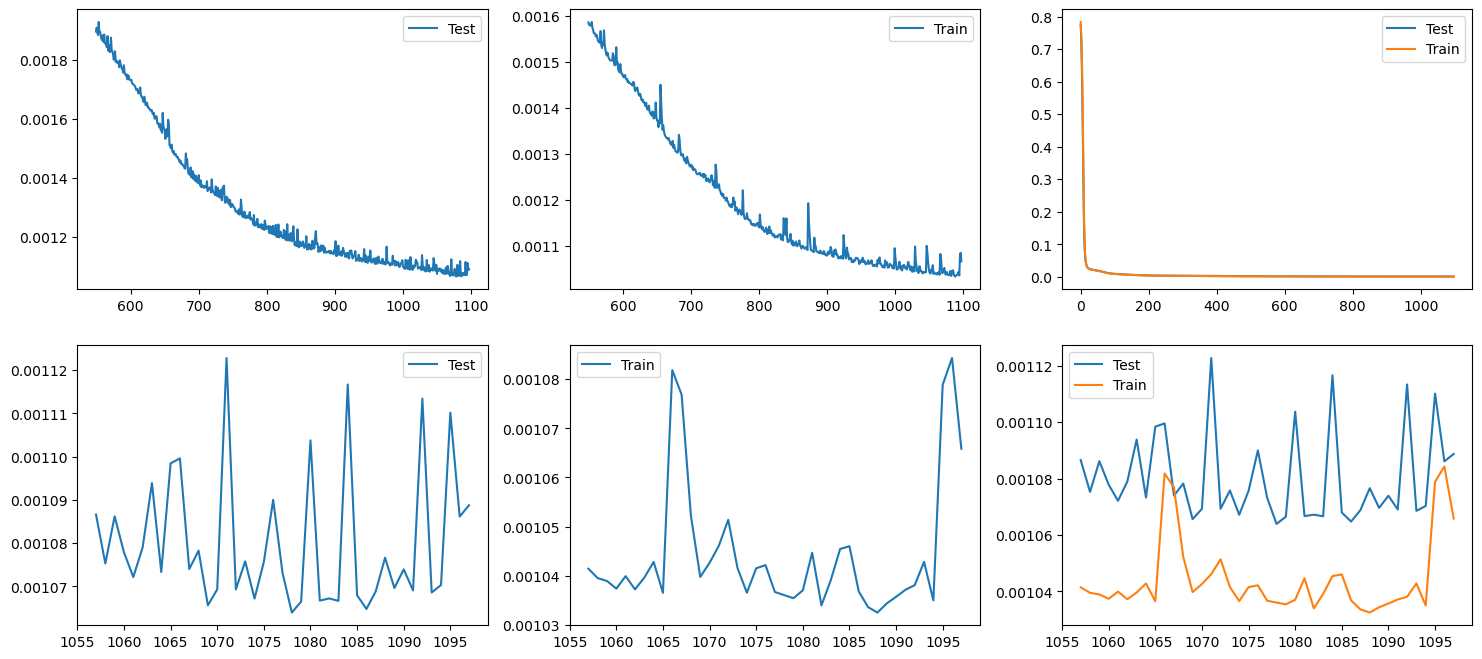

In [ ]:
cutStartPct = 0.5
zoomEndEpochs = 2 * config["patience"]
plot_helpers.plot_losses(
    [trainer.test_loss, trainer.train_loss],
    ["Test", "Train"],
    cutStartPct,
    zoomEndEpochs,
)

In [ ]:
x_test, y_test = test_dataset.tensors
# x_test=x_test.to(device)
y_test = y_test.squeeze().detach().cpu().numpy()
y_pred = best_model(x_test).squeeze().detach().cpu().numpy()

In [ ]:
y_text = r"$C_{14}$"

r2 = r2_score(y_test, y_pred)
r = np.corrcoef(y_test, y_pred)[0, 1]

print("Statistics for " + y_text)
print("R^2: %.4f" % np.mean(r2))
print("Correlation: %.4f" % +np.mean(r) + "\n")

Statistics for $C_{14}$
R^2: 0.9323
Correlation: 0.9656



Text(0.5, 1.0, '$C_{14}$')

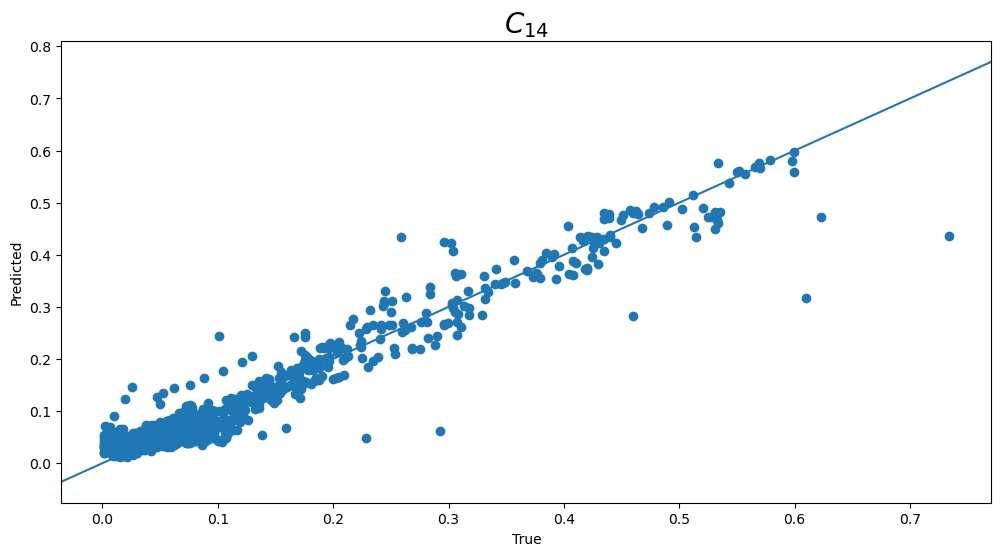

In [ ]:
l1 = "Predicted"
l2 = "True"
nvar = 1
# z=zt[0,:]
y_text = r"$C_{14}$"

# fig1,ax1 = plt.subplots(1,nvar,figsize = (12, 6))
fig2, ax2 = plt.subplots(1, nvar, figsize=(12, 6))
# fig3,ax3 = plt.subplots(1,nvar,figsize = (12, 6))

ax2.scatter(y_test, y_pred)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin, xmax], [xmin, xmax])
ax2.set_xlim([xmin, xmax])
# ax2.set_xlim([0,2])
# ax2.set_ylim([0,2])
ax2.set_xlabel(l2)
ax2.set_ylabel(l1)
ax2.set_title(y_text, fontsize=20)

Statistics for $C_{14}$
R^2: 0.9316
Correlation: 0.9654



Text(0.5, 1.0, '$C_{14}$')

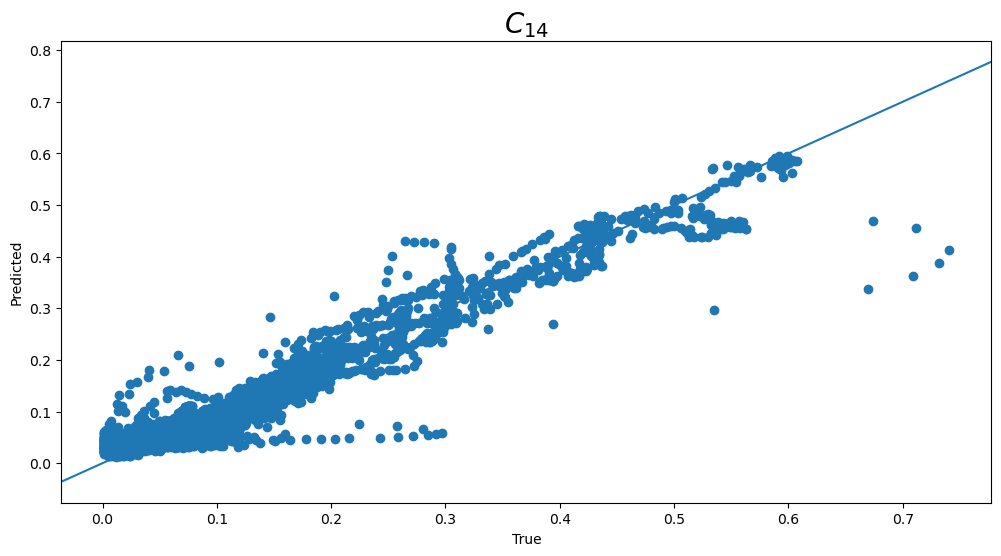

In [ ]:
x_test, y_test = train_dataset.tensors
# x_test=x_test.to(device)
y_test = y_test.squeeze().detach().cpu().numpy()
y_pred = best_model(x_test).squeeze().detach().cpu().numpy()

y_text = r"$C_{14}$"
r2 = r2_score(y_test, y_pred)
r = np.corrcoef(y_test, y_pred)[0, 1]

print("Statistics for " + y_text)
print("R^2: %.4f" % np.mean(r2))
print("Correlation: %.4f" % +np.mean(r) + "\n")

fig2, ax2 = plt.subplots(1, nvar, figsize=(12, 6))
# fig3,ax3 = plt.subplots(1,nvar,figsize = (12, 6))

ax2.scatter(y_test, y_pred)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin, xmax], [xmin, xmax])
ax2.set_xlim([xmin, xmax])
# ax2.set_xlim([0,2])
# ax2.set_ylim([0,2])
ax2.set_xlabel(l2)
ax2.set_ylabel(l1)
ax2.set_title(y_text, fontsize=20)

In [ ]:
# y_text=[r"$\overline{u'w'}/u_*^2$",r"$\overline{v'w'}/u_*^2$"]
# y_text=["U2DFSN","V2DFSN"]
# y_text[r'C_{14}']
# fig1,fig2,fig3=quickPlots(best_model,test_dataset,y_text,device)